In [1]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn

In [2]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [4]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [5]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')

    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [6]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [25]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 10000, 50000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',10,100),
        'random_strength': trial.suggest_uniform('random_strength',40,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
        'depth':trial.suggest_int('depth',3,10),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_uniform('bagging_temperature', 0, 1),
        'verbose':False,
        'random_state':seed,
    }
    
    #score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 early_stopping_rounds=100
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
    tmp_score = np.mean(tmp_score)
    return tmp_score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-14 02:10:16,973] A new study created in memory with name: no-name-807e848d-747f-4cfe-a653-0e5c84ec4cb0
[I 2024-02-14 02:11:00,665] Trial 0 finished with value: 0.7540990932105913 and parameters: {'iterations': 24981, 'learning_rate': 0.9507635921035062, 'reg_lambda': 75.87945476302646, 'random_strength': 75.91950905182219, 'min_data_in_leaf': 8, 'depth': 4, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.8661761457749352}. Best is trial 0 with value: 0.7540990932105913.
[I 2024-02-14 02:11:51,958] Trial 1 finished with value: 0.7653613997641913 and parameters: {'iterations': 34045, 'learning_rate': 0.7083645052182495, 'reg_lambda': 11.85260448662222, 'random_strength': 98.19459112971967, 'min_data_in_leaf': 42, 'depth': 4, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.18340450985343382}. Best is trial 1 with value: 0.7653613997641913.
[I 2024-02-14 02:12:44,509] Trial 2 finished with value: 0.7632852950274783 and parameters: {'iterations': 22169, 'learn

[I 2024-02-14 02:45:30,991] Trial 21 finished with value: 0.7757961755862608 and parameters: {'iterations': 42971, 'learning_rate': 0.6785843900731802, 'reg_lambda': 42.26772415997697, 'random_strength': 50.906681127716645, 'min_data_in_leaf': 38, 'depth': 9, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.9913241603945139}. Best is trial 18 with value: 0.7800812115815831.
[I 2024-02-14 02:46:58,949] Trial 22 finished with value: 0.7744075658085885 and parameters: {'iterations': 44066, 'learning_rate': 0.630566244617138, 'reg_lambda': 24.92880189240119, 'random_strength': 46.37973190696476, 'min_data_in_leaf': 44, 'depth': 9, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.7700612200174363}. Best is trial 18 with value: 0.7800812115815831.
[I 2024-02-14 02:49:02,169] Trial 23 finished with value: 0.7656826598807545 and parameters: {'iterations': 40805, 'learning_rate': 0.43523545532817964, 'reg_lambda': 51.16756015310742, 'random_strength': 54.09478129434562, 'min_d

[I 2024-02-14 03:19:32,291] Trial 43 finished with value: 0.7714259286030695 and parameters: {'iterations': 38131, 'learning_rate': 0.5478288825168244, 'reg_lambda': 41.17880824938461, 'random_strength': 60.672015585138226, 'min_data_in_leaf': 50, 'depth': 9, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.9547195629534985}. Best is trial 18 with value: 0.7800812115815831.
[I 2024-02-14 03:21:07,516] Trial 44 finished with value: 0.7724753880921094 and parameters: {'iterations': 40253, 'learning_rate': 0.8531696500626506, 'reg_lambda': 33.19741426959863, 'random_strength': 50.65196309989763, 'min_data_in_leaf': 45, 'depth': 10, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.8898661819034739}. Best is trial 18 with value: 0.7800812115815831.
[I 2024-02-14 03:23:29,668] Trial 45 finished with value: 0.7729566985063123 and parameters: {'iterations': 49834, 'learning_rate': 0.14731032428204277, 'reg_lambda': 36.592358459451376, 'random_strength': 97.96163916834648, 'mi

[I 2024-02-14 04:10:49,349] Trial 65 finished with value: 0.7840902208616904 and parameters: {'iterations': 23668, 'learning_rate': 0.2914156814553512, 'reg_lambda': 85.45729764749957, 'random_strength': 87.7006952070361, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.6690564750994255}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 04:13:10,839] Trial 66 finished with value: 0.7770164284117121 and parameters: {'iterations': 23466, 'learning_rate': 0.28149237488431306, 'reg_lambda': 85.9047398345903, 'random_strength': 88.67190426670885, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.7448329355565046}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 04:16:56,020] Trial 67 finished with value: 0.7793484151733613 and parameters: {'iterations': 18075, 'learning_rate': 0.11547433508715678, 'reg_lambda': 79.46802199454076, 'random_strength': 93.27986338789955, 'mi

[I 2024-02-14 05:18:24,375] Trial 87 finished with value: 0.7812148837938989 and parameters: {'iterations': 22370, 'learning_rate': 0.1380787102844862, 'reg_lambda': 99.91503615610127, 'random_strength': 82.30619976503722, 'min_data_in_leaf': 42, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.9653734603869846}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 05:24:14,132] Trial 88 finished with value: 0.7750981492302492 and parameters: {'iterations': 26891, 'learning_rate': 0.04547728219734884, 'reg_lambda': 86.42547150353896, 'random_strength': 89.50515318118683, 'min_data_in_leaf': 46, 'depth': 9, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.9221715342252675}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 05:26:37,939] Trial 89 finished with value: 0.7800682029845093 and parameters: {'iterations': 25160, 'learning_rate': 0.2938793007812174, 'reg_lambda': 83.72357337124699, 'random_strength': 98.00535558396055, 'mi

[I 2024-02-14 06:20:05,560] Trial 109 finished with value: 0.7767637956243914 and parameters: {'iterations': 32508, 'learning_rate': 0.26849437817150273, 'reg_lambda': 91.54515565224153, 'random_strength': 97.71360821790405, 'min_data_in_leaf': 49, 'depth': 9, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.34406145192278864}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 06:22:14,272] Trial 110 finished with value: 0.7779578082863889 and parameters: {'iterations': 30697, 'learning_rate': 0.3337460729666929, 'reg_lambda': 98.66882086641769, 'random_strength': 91.63809303206567, 'min_data_in_leaf': 47, 'depth': 9, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.9036534142697312}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 06:24:49,933] Trial 111 finished with value: 0.7827395699207081 and parameters: {'iterations': 32875, 'learning_rate': 0.2793975141258459, 'reg_lambda': 84.31339293974749, 'random_strength': 89.19188173151124, 

[I 2024-02-14 07:25:11,182] Trial 131 finished with value: 0.7724678309174013 and parameters: {'iterations': 26305, 'learning_rate': 0.2213162732888312, 'reg_lambda': 78.89730261736202, 'random_strength': 96.3468287956369, 'min_data_in_leaf': 49, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2461043047487259}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 07:27:24,045] Trial 132 finished with value: 0.777238013019115 and parameters: {'iterations': 23065, 'learning_rate': 0.37702380891133896, 'reg_lambda': 84.86684039206892, 'random_strength': 94.95908176348773, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.21330029360563463}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 07:29:59,921] Trial 133 finished with value: 0.786089619851724 and parameters: {'iterations': 27862, 'learning_rate': 0.28554807155495915, 'reg_lambda': 88.33280737238933, 'random_strength': 96.42181141194934, 

[I 2024-02-14 08:23:22,397] Trial 153 finished with value: 0.7741875934252271 and parameters: {'iterations': 25942, 'learning_rate': 0.27894946214689864, 'reg_lambda': 99.79941050876839, 'random_strength': 97.30683406992576, 'min_data_in_leaf': 14, 'depth': 10, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.04937750543193916}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 08:25:59,839] Trial 154 finished with value: 0.7868568102683213 and parameters: {'iterations': 22757, 'learning_rate': 0.3162414315903783, 'reg_lambda': 97.1136557388953, 'random_strength': 95.30055279520745, 'min_data_in_leaf': 5, 'depth': 10, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.21996383835039612}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 08:28:17,277] Trial 155 finished with value: 0.7765537166920982 and parameters: {'iterations': 25257, 'learning_rate': 0.33114881519521144, 'reg_lambda': 96.87489807085029, 'random_strength': 94.90227956105436

[I 2024-02-14 09:21:07,422] Trial 175 finished with value: 0.779322257489895 and parameters: {'iterations': 26880, 'learning_rate': 0.18215117169477474, 'reg_lambda': 96.85011422492916, 'random_strength': 92.96943627610216, 'min_data_in_leaf': 6, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.11703817972406082}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 09:24:32,118] Trial 176 finished with value: 0.7858489346482622 and parameters: {'iterations': 25523, 'learning_rate': 0.16515733129257076, 'reg_lambda': 92.3451916503619, 'random_strength': 97.69664519464143, 'min_data_in_leaf': 22, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2164751559710582}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 09:28:27,784] Trial 177 finished with value: 0.7808341963768057 and parameters: {'iterations': 20870, 'learning_rate': 0.10483284609053099, 'reg_lambda': 88.53906114696866, 'random_strength': 65.69486047289908,

[I 2024-02-14 10:26:36,562] Trial 197 finished with value: 0.7766884028769717 and parameters: {'iterations': 22626, 'learning_rate': 0.2627254363205639, 'reg_lambda': 87.68627554849307, 'random_strength': 93.45512208127057, 'min_data_in_leaf': 27, 'depth': 10, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.2753334328012201}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 10:29:05,533] Trial 198 finished with value: 0.7863346182166168 and parameters: {'iterations': 21779, 'learning_rate': 0.31056551951627487, 'reg_lambda': 89.41079141639622, 'random_strength': 76.7169347018924, 'min_data_in_leaf': 25, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3351667031410151}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 10:31:10,612] Trial 199 finished with value: 0.7793076328819203 and parameters: {'iterations': 22186, 'learning_rate': 0.37168133307882534, 'reg_lambda': 89.85247735867824, 'random_strength': 97.00630878132063, 

[I 2024-02-14 11:24:24,279] Trial 219 finished with value: 0.7867695084273738 and parameters: {'iterations': 22169, 'learning_rate': 0.18425244942313995, 'reg_lambda': 96.11861589694945, 'random_strength': 74.09999493350645, 'min_data_in_leaf': 47, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.23603966492937542}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 11:27:07,621] Trial 220 finished with value: 0.769721395529463 and parameters: {'iterations': 21210, 'learning_rate': 0.17935812376053242, 'reg_lambda': 96.02107547118467, 'random_strength': 73.97955020989284, 'min_data_in_leaf': 49, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.23790658631286404}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 11:29:58,083] Trial 221 finished with value: 0.7758477648866882 and parameters: {'iterations': 22305, 'learning_rate': 0.19958501859192662, 'reg_lambda': 97.64668605388974, 'random_strength': 96.833504250571

[I 2024-02-14 12:27:23,333] Trial 241 finished with value: 0.78126278431785 and parameters: {'iterations': 25356, 'learning_rate': 0.29555210455312814, 'reg_lambda': 39.24102415153586, 'random_strength': 97.71005994259184, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.9581006542223084}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 12:30:08,860] Trial 242 finished with value: 0.7868553546735895 and parameters: {'iterations': 24515, 'learning_rate': 0.2580368014725052, 'reg_lambda': 89.51161116478383, 'random_strength': 96.527580708378, 'min_data_in_leaf': 46, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.97781480590322}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 12:31:36,407] Trial 243 finished with value: 0.7651037852033357 and parameters: {'iterations': 24529, 'learning_rate': 0.24648279474275603, 'reg_lambda': 37.181666291224474, 'random_strength': 98.34046629793656, 'mi

[I 2024-02-14 13:21:22,573] Trial 263 finished with value: 0.779443361677397 and parameters: {'iterations': 23476, 'learning_rate': 0.1984327756428464, 'reg_lambda': 93.06116172268145, 'random_strength': 97.73690040003379, 'min_data_in_leaf': 38, 'depth': 10, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.3080122512285463}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 13:23:45,612] Trial 264 finished with value: 0.778704410981811 and parameters: {'iterations': 25818, 'learning_rate': 0.26062395507216707, 'reg_lambda': 43.92325363601113, 'random_strength': 93.69053680717892, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2631293410179641}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 13:26:01,588] Trial 265 finished with value: 0.7744483862992045 and parameters: {'iterations': 23922, 'learning_rate': 0.30714606922986787, 'reg_lambda': 96.47353195946309, 'random_strength': 95.72385471787241, 

[I 2024-02-14 14:16:33,688] Trial 285 finished with value: 0.7707420277588622 and parameters: {'iterations': 23574, 'learning_rate': 0.20907534162438438, 'reg_lambda': 49.115157566746966, 'random_strength': 40.23381521092428, 'min_data_in_leaf': 47, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.26664756859554006}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 14:18:50,100] Trial 286 finished with value: 0.7832657111888726 and parameters: {'iterations': 25950, 'learning_rate': 0.25440997004615085, 'reg_lambda': 53.048293610352154, 'random_strength': 99.89439439127658, 'min_data_in_leaf': 49, 'depth': 10, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.23414369503570265}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 14:22:22,983] Trial 287 finished with value: 0.7809397647227507 and parameters: {'iterations': 24510, 'learning_rate': 0.1530138500195693, 'reg_lambda': 93.80836967324322, 'random_strength': 96.5268802283

[I 2024-02-14 15:12:20,606] Trial 307 finished with value: 0.762496519098058 and parameters: {'iterations': 22278, 'learning_rate': 0.8884470542235032, 'reg_lambda': 94.38009304099184, 'random_strength': 97.75527373295796, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.27028007120713765}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 15:15:15,173] Trial 308 finished with value: 0.7818142323370993 and parameters: {'iterations': 21295, 'learning_rate': 0.19311134522527396, 'reg_lambda': 98.30047385599431, 'random_strength': 99.99558794522285, 'min_data_in_leaf': 22, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2041456735496696}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 15:17:31,675] Trial 309 finished with value: 0.7812731893305199 and parameters: {'iterations': 23024, 'learning_rate': 0.27223797519776344, 'reg_lambda': 51.35651771233486, 'random_strength': 98.20653772934247

[I 2024-02-14 16:05:34,470] Trial 329 finished with value: 0.7828116714118319 and parameters: {'iterations': 23928, 'learning_rate': 0.21360483113380418, 'reg_lambda': 73.05843019837735, 'random_strength': 98.50470430132752, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.9511529887325315}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 16:08:06,949] Trial 330 finished with value: 0.7886857265023763 and parameters: {'iterations': 25515, 'learning_rate': 0.30254769811840554, 'reg_lambda': 91.33058778400249, 'random_strength': 96.34675437197744, 'min_data_in_leaf': 45, 'depth': 10, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.27963174923305384}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 16:09:33,917] Trial 331 finished with value: 0.7681481424675913 and parameters: {'iterations': 25317, 'learning_rate': 0.30383992543030097, 'reg_lambda': 91.344644822715, 'random_strength': 94.10257267937807

[I 2024-02-14 17:01:29,330] Trial 351 finished with value: 0.7794434725802416 and parameters: {'iterations': 24168, 'learning_rate': 0.2817760639260539, 'reg_lambda': 93.07519912828494, 'random_strength': 91.09557721589067, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2173401834853212}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 17:04:51,348] Trial 352 finished with value: 0.7878489161412106 and parameters: {'iterations': 16550, 'learning_rate': 0.2005536798391175, 'reg_lambda': 95.22457313902241, 'random_strength': 98.97811793939384, 'min_data_in_leaf': 2, 'depth': 10, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2995542121399727}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 17:07:19,929] Trial 353 finished with value: 0.7778802667636077 and parameters: {'iterations': 16644, 'learning_rate': 0.23641235027868657, 'reg_lambda': 96.02049819072356, 'random_strength': 99.061225877089, 'm

[I 2024-02-14 18:06:21,311] Trial 373 finished with value: 0.7813149836514321 and parameters: {'iterations': 19037, 'learning_rate': 0.0968507102050228, 'reg_lambda': 30.675484446336824, 'random_strength': 99.8937138107414, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.39265883357546427}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 18:09:19,614] Trial 374 finished with value: 0.7811217246558608 and parameters: {'iterations': 19615, 'learning_rate': 0.1393388670540609, 'reg_lambda': 32.678004534499635, 'random_strength': 67.01003704477671, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3335983780822429}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 18:13:45,752] Trial 375 finished with value: 0.771779923958462 and parameters: {'iterations': 20611, 'learning_rate': 0.057415925561644404, 'reg_lambda': 34.02226771008114, 'random_strength': 66.0745634364520

[I 2024-02-14 19:17:20,091] Trial 395 finished with value: 0.7888587759755376 and parameters: {'iterations': 18872, 'learning_rate': 0.09418875309412061, 'reg_lambda': 12.386526686543629, 'random_strength': 54.146434121815275, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3692667570474548}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 19:21:33,319] Trial 396 finished with value: 0.7897626775785158 and parameters: {'iterations': 17958, 'learning_rate': 0.07005091957662551, 'reg_lambda': 12.101012669718614, 'random_strength': 50.78090888130162, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.39463078246080935}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 19:26:20,461] Trial 397 finished with value: 0.7831444162377352 and parameters: {'iterations': 17814, 'learning_rate': 0.05105511944767427, 'reg_lambda': 11.723631420235014, 'random_strength': 52.20884561

[I 2024-02-14 20:45:01,851] Trial 416 finished with value: 0.7854768575562189 and parameters: {'iterations': 16943, 'learning_rate': 0.0384345723399003, 'reg_lambda': 17.395502337813248, 'random_strength': 51.10358597781584, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.4047408588306539}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 20:47:29,647] Trial 417 finished with value: 0.7761767116841142 and parameters: {'iterations': 16941, 'learning_rate': 0.11705533145104181, 'reg_lambda': 18.73244376589248, 'random_strength': 55.54154342078241, 'min_data_in_leaf': 50, 'depth': 7, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.355764267029071}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 20:51:48,825] Trial 418 finished with value: 0.7795559455228197 and parameters: {'iterations': 18143, 'learning_rate': 0.05996741049018778, 'reg_lambda': 15.780728031800937, 'random_strength': 52.59301111257829

[I 2024-02-14 22:01:37,773] Trial 438 finished with value: 0.785353061226835 and parameters: {'iterations': 16365, 'learning_rate': 0.12348228775966608, 'reg_lambda': 11.269578790985749, 'random_strength': 49.68561425796361, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.41088600528078834}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 22:04:25,433] Trial 439 finished with value: 0.7881328985050835 and parameters: {'iterations': 17147, 'learning_rate': 0.13673038986285496, 'reg_lambda': 13.124450785934878, 'random_strength': 50.1295128061656, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.4016482897313404}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 22:07:12,788] Trial 440 finished with value: 0.7876491719602722 and parameters: {'iterations': 17831, 'learning_rate': 0.13880614328948537, 'reg_lambda': 12.520962728824804, 'random_strength': 47.42404578907

[I 2024-02-14 23:19:39,791] Trial 460 finished with value: 0.7864466606490688 and parameters: {'iterations': 16649, 'learning_rate': 0.05517517399857459, 'reg_lambda': 10.123056679380316, 'random_strength': 44.535939794322296, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3999857902645493}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 23:23:16,569] Trial 461 finished with value: 0.7830565677685157 and parameters: {'iterations': 14318, 'learning_rate': 0.0864078519076725, 'reg_lambda': 19.986377009648052, 'random_strength': 86.94366910774227, 'min_data_in_leaf': 48, 'depth': 10, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.37015390858565855}. Best is trial 51 with value: 0.7962880004923082.
[I 2024-02-14 23:27:56,115] Trial 462 finished with value: 0.7912475376917064 and parameters: {'iterations': 17355, 'learning_rate': 0.06203509133173338, 'reg_lambda': 11.935633204998473, 'random_strength': 54.297840718

KeyboardInterrupt: 

In [76]:
best_param = study.best_params
best_param = {'iterations': 18123, 'learning_rate': 0.11913282427946972, 'reg_lambda': 16.623192271833734, 'random_strength': 52.53589438459474, 'min_data_in_leaf': 50, 'depth': 10, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.36084106802257787}

{'iterations': 18588,
 'learning_rate': 0.23742604422190233,
 'reg_lambda': 86.47639327156247,
 'random_strength': 93.48361472460124,
 'min_data_in_leaf': 46,
 'depth': 10,
 'leaf_estimation_iterations': 11,
 'bagging_temperature': 0.9291029900394671}

In [77]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                verbose=False,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [78]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [79]:
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4608    12]
 [  579 50581]]

정확도: 0.9894
정밀도: 0.8884
재현율: 0.9974
F1: 0.9397


In [80]:
threshold

0.11648811236482089

In [81]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [82]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred[:], axis=0)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1706

In [86]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = custom_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [83]:
real = pd.read_csv(r'submission(0.767).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1630  142]
 [  76 3423]]

정확도: 0.9586
정밀도: 0.9555
재현율: 0.9199
F1: 0.9373


In [84]:
real = pd.read_csv(r'submission(0.768524-110-1755).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1622  133]
 [  84 3432]]

정확도: 0.9588
정밀도: 0.9508
재현율: 0.9242
F1: 0.9373


In [85]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1839

In [87]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

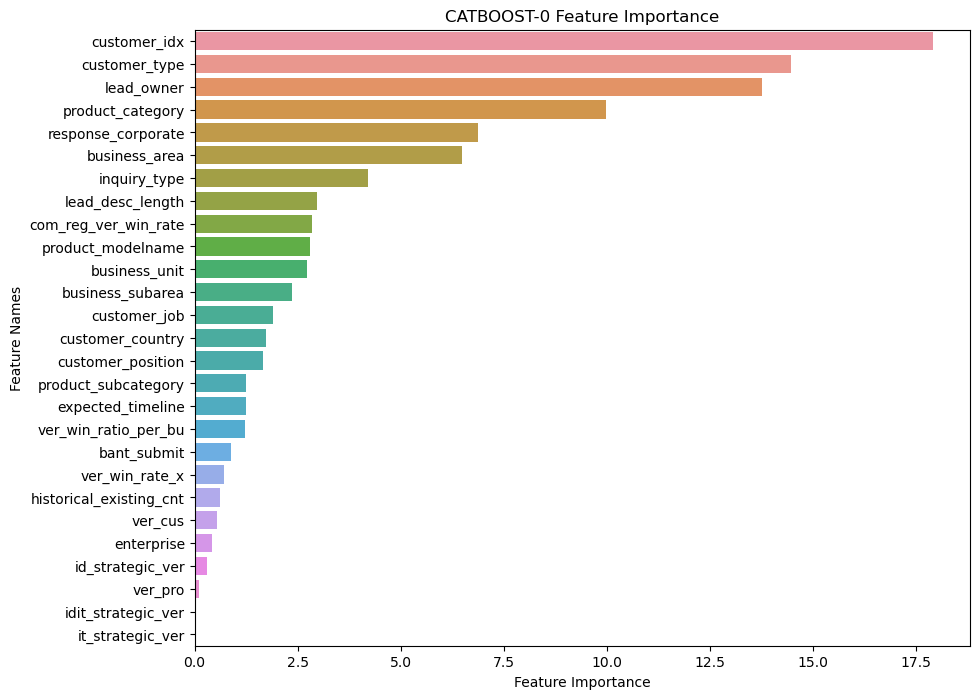

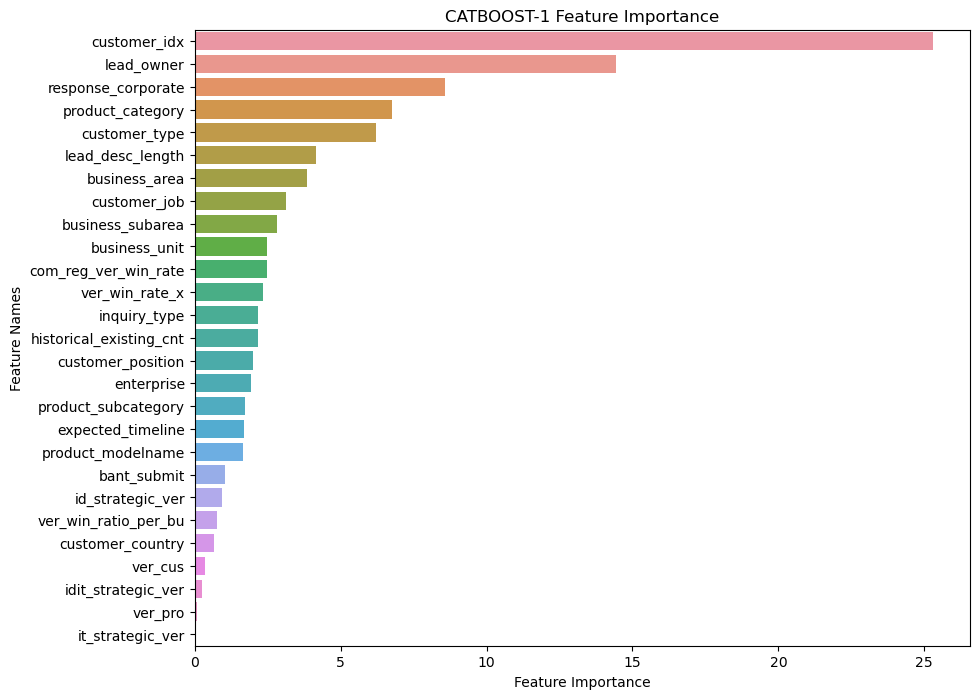

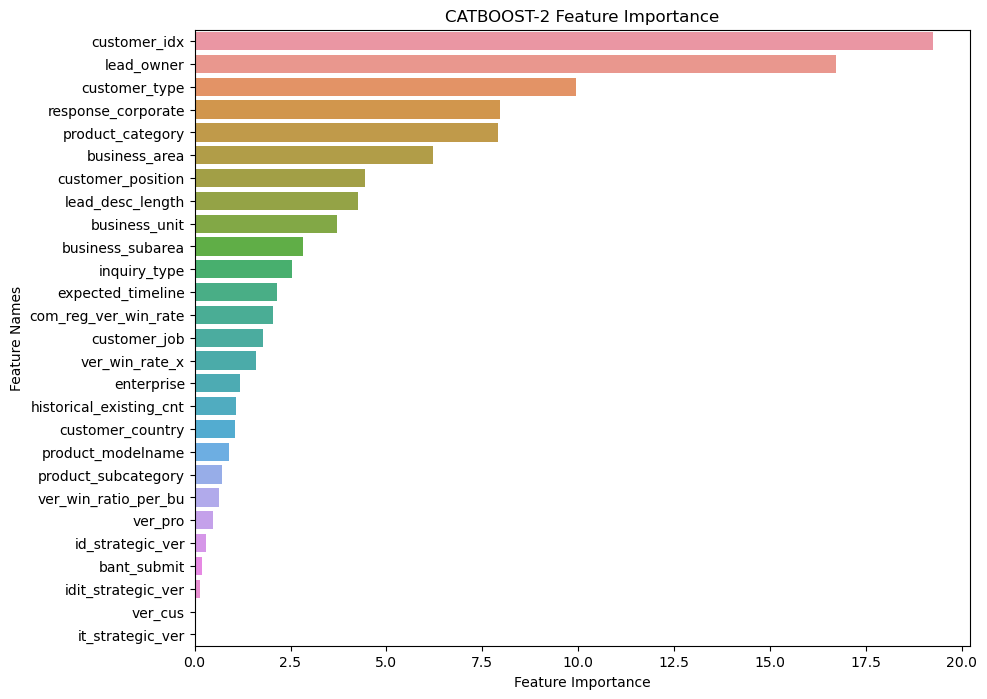

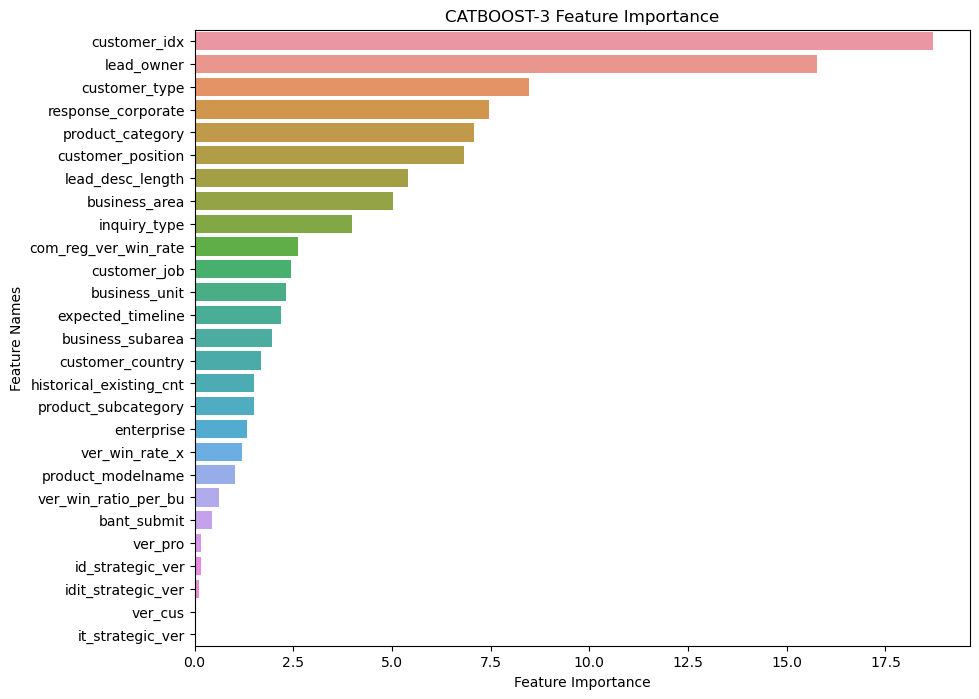

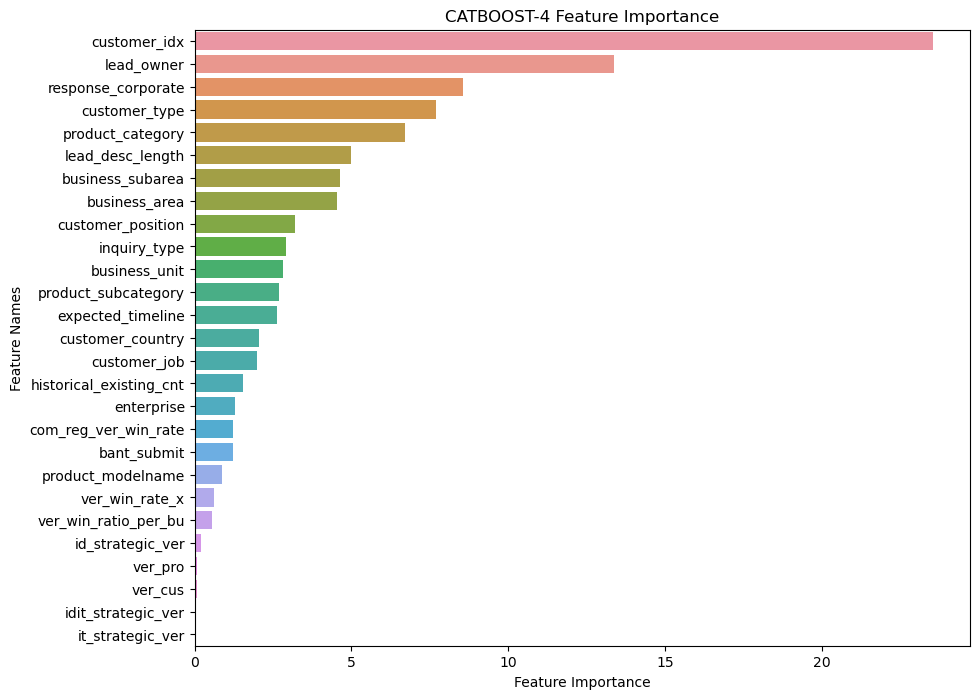

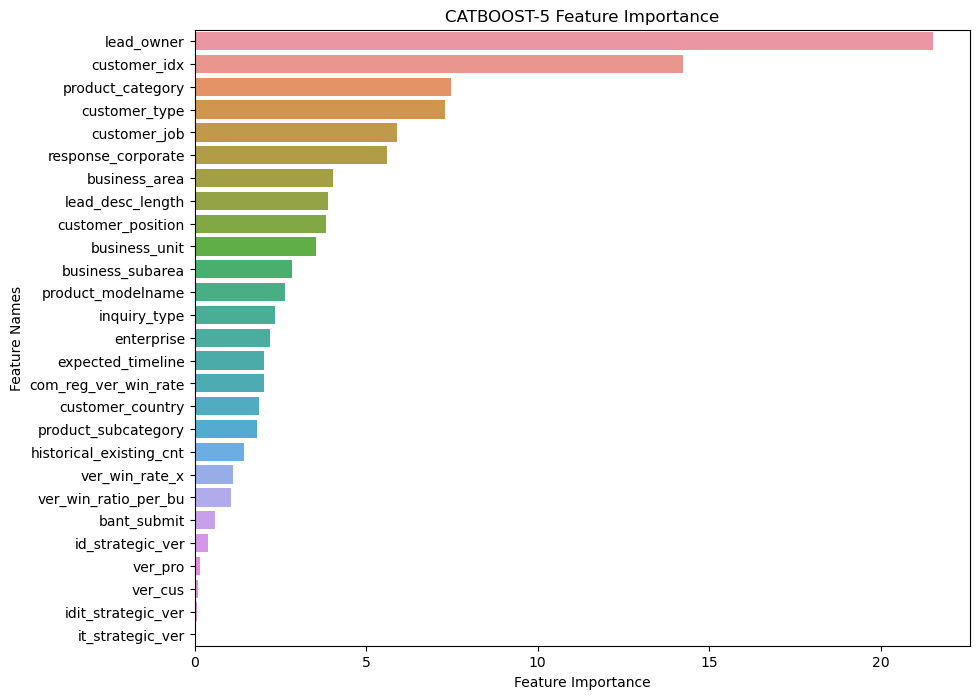

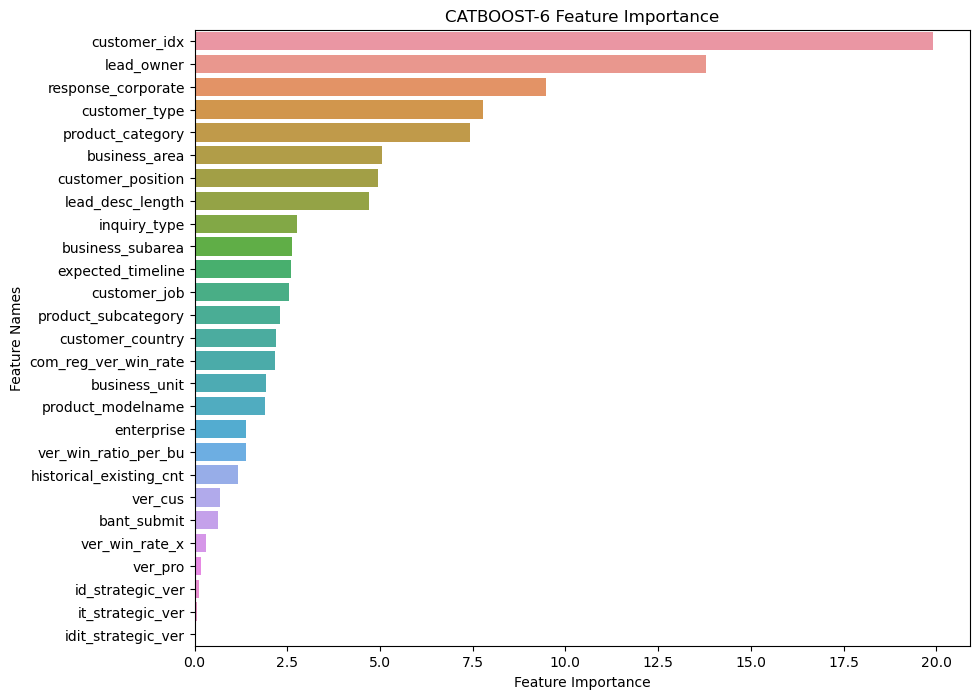

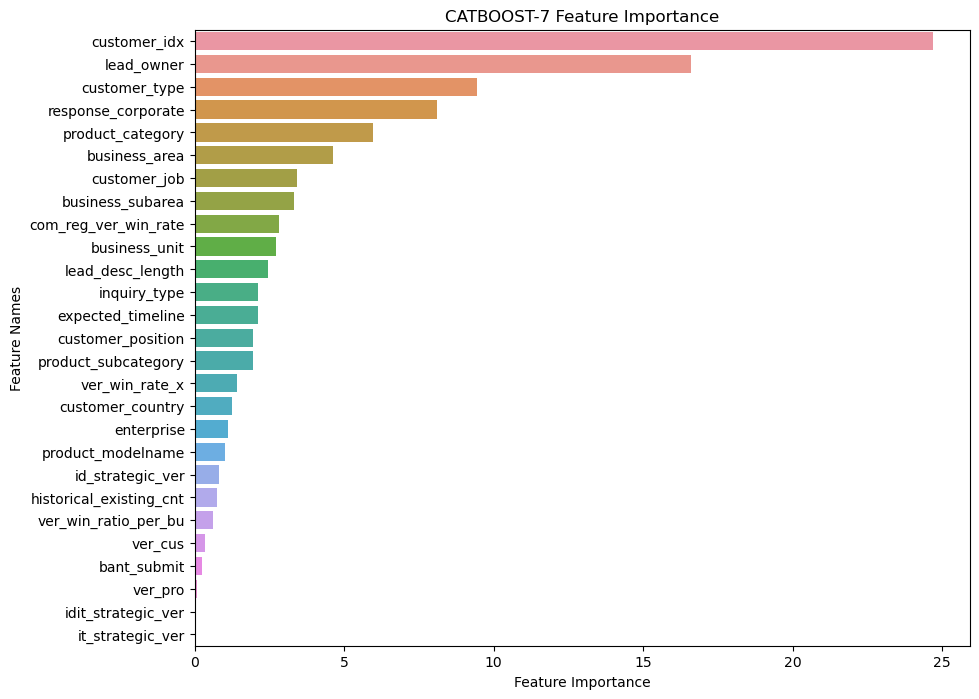

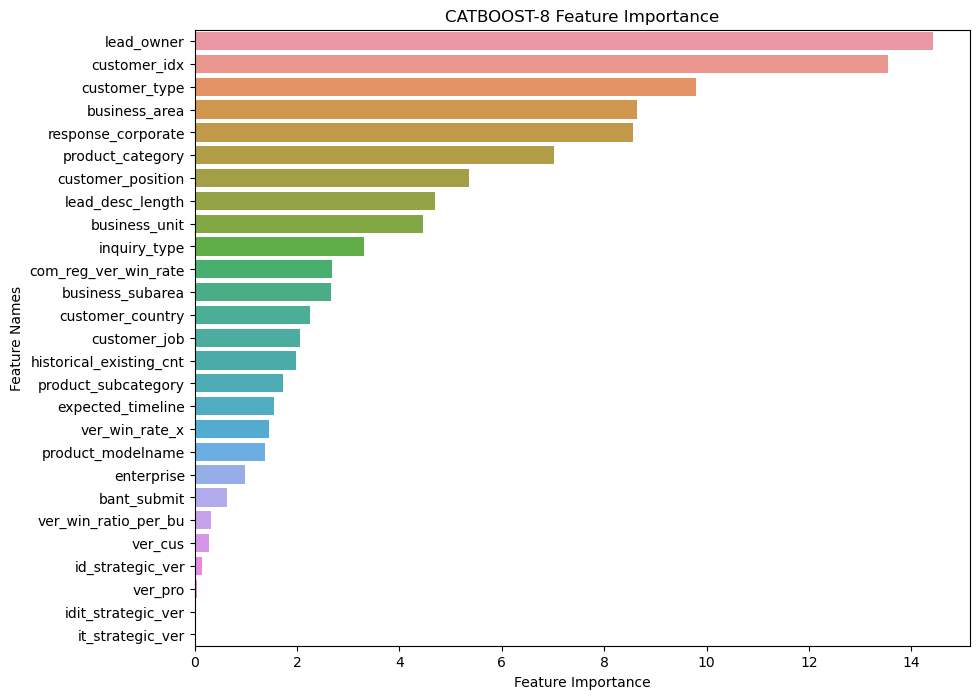

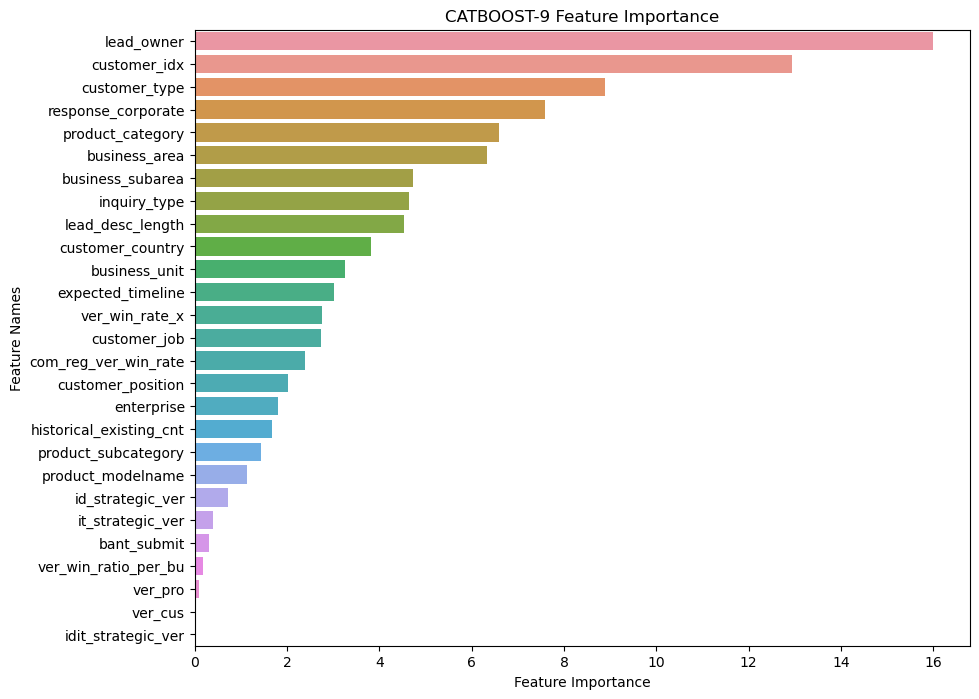

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [69]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4606    14]
 [  651 50509]]

정확도: 0.9881
정밀도: 0.8762
재현율: 0.9970
F1: 0.9327


In [70]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_val_pool[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_val[i], train_pred)

오차행렬:
 [[ 462    0]
 [  88 5028]]

정확도: 0.9842
정밀도: 0.8400
재현율: 1.0000
F1: 0.9130
오차행렬:
 [[ 461    1]
 [  62 5054]]

정확도: 0.9887
정밀도: 0.8815
재현율: 0.9978
F1: 0.9360
오차행렬:
 [[ 460    2]
 [  61 5055]]

정확도: 0.9887
정밀도: 0.8829
재현율: 0.9957
F1: 0.9359
오차행렬:
 [[ 460    2]
 [  65 5051]]

정확도: 0.9880
정밀도: 0.8762
재현율: 0.9957
F1: 0.9321
오차행렬:
 [[ 461    1]
 [  72 5044]]

정확도: 0.9869
정밀도: 0.8649
재현율: 0.9978
F1: 0.9266
오차행렬:
 [[ 459    3]
 [  54 5062]]

정확도: 0.9898
정밀도: 0.8947
재현율: 0.9935
F1: 0.9415
오차행렬:
 [[ 462    0]
 [  68 5048]]

정확도: 0.9878
정밀도: 0.8717
재현율: 1.0000
F1: 0.9315
오차행렬:
 [[ 462    0]
 [  61 5055]]

정확도: 0.9891
정밀도: 0.8834
재현율: 1.0000
F1: 0.9381
오차행렬:
 [[ 458    4]
 [  65 5051]]

정확도: 0.9876
정밀도: 0.8757
재현율: 0.9913
F1: 0.9299
오차행렬:
 [[ 461    1]
 [  55 5061]]

정확도: 0.9900
정밀도: 0.8934
재현율: 0.9978
F1: 0.9427
